In [1]:
import math

import import_ipynb
from utils import df_from_csv, to_be_checked, is_corr_ok, plot_hist, plot_boxes, plot_lines, df_to_csv, drop_pm25_outliers

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from aqi_epa_pm25.ipynb
PM2.5: 35.9, AQI: 102
PM2.5: 35.9, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 35.5, Max: 55.4
AQI: 102, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 101, Max: 150


## PM2.5 Clean Data

In [2]:
# Load Raw Data
df_pm25_raw = df_from_csv("pm25_raw.csv")

# Check Data Types
print(df_pm25_raw.dtypes)

df_pm25_raw.head()

TANGARA_2BBA    float64
TANGARA_260A    float64
TANGARA_4B1A    float64
TANGARA_1EE6    float64
TANGARA_2B42    float64
TANGARA_2E9A    float64
TANGARA_2FF6    float64
TANGARA_307A    float64
TANGARA_1712    float64
TANGARA_48C6    float64
TANGARA_532E    float64
TANGARA_F1AE    float64
TANGARA_06BE    float64
dtype: object


,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
DATETIME,,,,,,,,,,,,,
2023-10-05 19:17:00-05:00,3.0,4.0,49.0,NaN,NaN,16.0,3.0,9.0,14.0,NaN,23.0,NaN,NaN
2023-10-05 19:17:30-05:00,3.0,3.0,40.0,15.0,2.0,15.0,3.0,8.0,13.0,5.0,NaN,3.0,0.0
2023-10-05 19:18:00-05:00,3.0,4.0,35.0,15.0,2.0,15.0,3.0,8.0,12.0,4.0,22.0,3.0,0.0
2023-10-05 19:18:30-05:00,2.0,4.0,29.0,16.0,2.0,14.0,3.0,9.0,12.0,5.0,27.0,3.0,0.0
2023-10-05 19:19:00-05:00,3.0,4.0,28.0,15.0,2.0,15.0,3.0,9.0,12.0,5.0,23.0,3.0,0.0


## Descriptive Statistics

In [3]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,111.000000,108.000000,107.000000,107.000000,109.000000,107.000000,108.000000,106.000000,108.000000,103.000000,107.000000,110.000000,107.0
mean,4.648649,4.888889,15.112150,16.700935,5.486239,20.130841,5.444444,11.745283,16.916667,6.242718,13.981308,2.872727,0.0
std,2.061106,3.867751,9.590018,8.803103,2.651396,7.842896,2.923745,1.831270,5.995520,2.064955,5.268241,0.665108,0.0
min,2.000000,2.000000,5.000000,7.000000,2.000000,11.000000,3.000000,8.000000,11.000000,2.000000,6.000000,2.000000,0.0
25%,3.000000,3.000000,8.000000,11.000000,4.000000,15.000000,4.000000,11.000000,13.000000,5.000000,10.000000,2.250000,0.0
50%,4.000000,3.000000,12.000000,13.000000,5.000000,17.000000,4.000000,12.000000,15.000000,6.000000,13.000000,3.000000,0.0
75%,6.000000,4.000000,19.500000,21.000000,7.000000,24.000000,6.000000,13.000000,18.000000,7.500000,17.000000,3.000000,0.0
max,9.000000,17.000000,49.000000,40.000000,13.000000,41.000000,12.000000,17.000000,33.000000,12.000000,27.000000,6.000000,0.0


## Missing Data

In [4]:
# Missing Data Threshold
threshold = 90
print(f'Threshold: {threshold}%')

# For each Tangara sensor
for id_tangara_sensor in df_pm25_raw.columns:
    df_pm25_sensor = df_pm25_raw[[id_tangara_sensor]]
    # To be checked
    is_ok, data_percent, missing_data_percent = to_be_checked(df_pm25_sensor, threshold)
    if not is_ok:
        print(f"Tangara Sensor: {id_tangara_sensor}, Data: {data_percent}%, Missing: {missing_data_percent}%, To be checked")

Threshold: 90%
Tangara Sensor: TANGARA_260A, Data: 89%, Missing: 11%, To be checked
Tangara Sensor: TANGARA_4B1A, Data: 88%, Missing: 12%, To be checked
Tangara Sensor: TANGARA_1EE6, Data: 88%, Missing: 12%, To be checked
Tangara Sensor: TANGARA_2E9A, Data: 88%, Missing: 12%, To be checked
Tangara Sensor: TANGARA_2FF6, Data: 89%, Missing: 11%, To be checked
Tangara Sensor: TANGARA_307A, Data: 88%, Missing: 12%, To be checked
Tangara Sensor: TANGARA_1712, Data: 89%, Missing: 11%, To be checked
Tangara Sensor: TANGARA_48C6, Data: 85%, Missing: 15%, To be checked
Tangara Sensor: TANGARA_532E, Data: 88%, Missing: 12%, To be checked
Tangara Sensor: TANGARA_06BE, Data: 88%, Missing: 12%, To be checked


## Data Correlation

In [5]:
# Data Correlation Threshold
threshold = 0.9
print(f'Threshold: {threshold}%')

ID_REFE_TANGARA_SENSOR='TANGARA_06BE'
ID_TARG_TANGARA_SENSOR='TANGARA_2FF6'
# Reference Tangara Sensor
df_reference_sensor = df_pm25_raw[ID_REFE_TANGARA_SENSOR]
# Target Tangara Sensor
df_target_sensor = df_pm25_raw[ID_TARG_TANGARA_SENSOR]

# To be checked
is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
if not is_ok:
    print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {ID_TARG_TANGARA_SENSOR}, Correlation: {corr}, To be checked")

# For each Tangara sensor
# for id_tangara_sensor in df_pm25_raw.columns:
#     # Target Tangara Sensor
#     df_target_sensor = df_pm25_raw[id_tangara_sensor]
#     # To be checked
#     is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
#     if not is_ok:
#         print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {id_tangara_sensor}, Correlation: {corr}, To be checked")

Threshold: 0.9%
Reference Tangara Sensor: TANGARA_06BE, Target Tangara Sensor: TANGARA_2FF6, Correlation: 0.0, To be checked


## Histograms

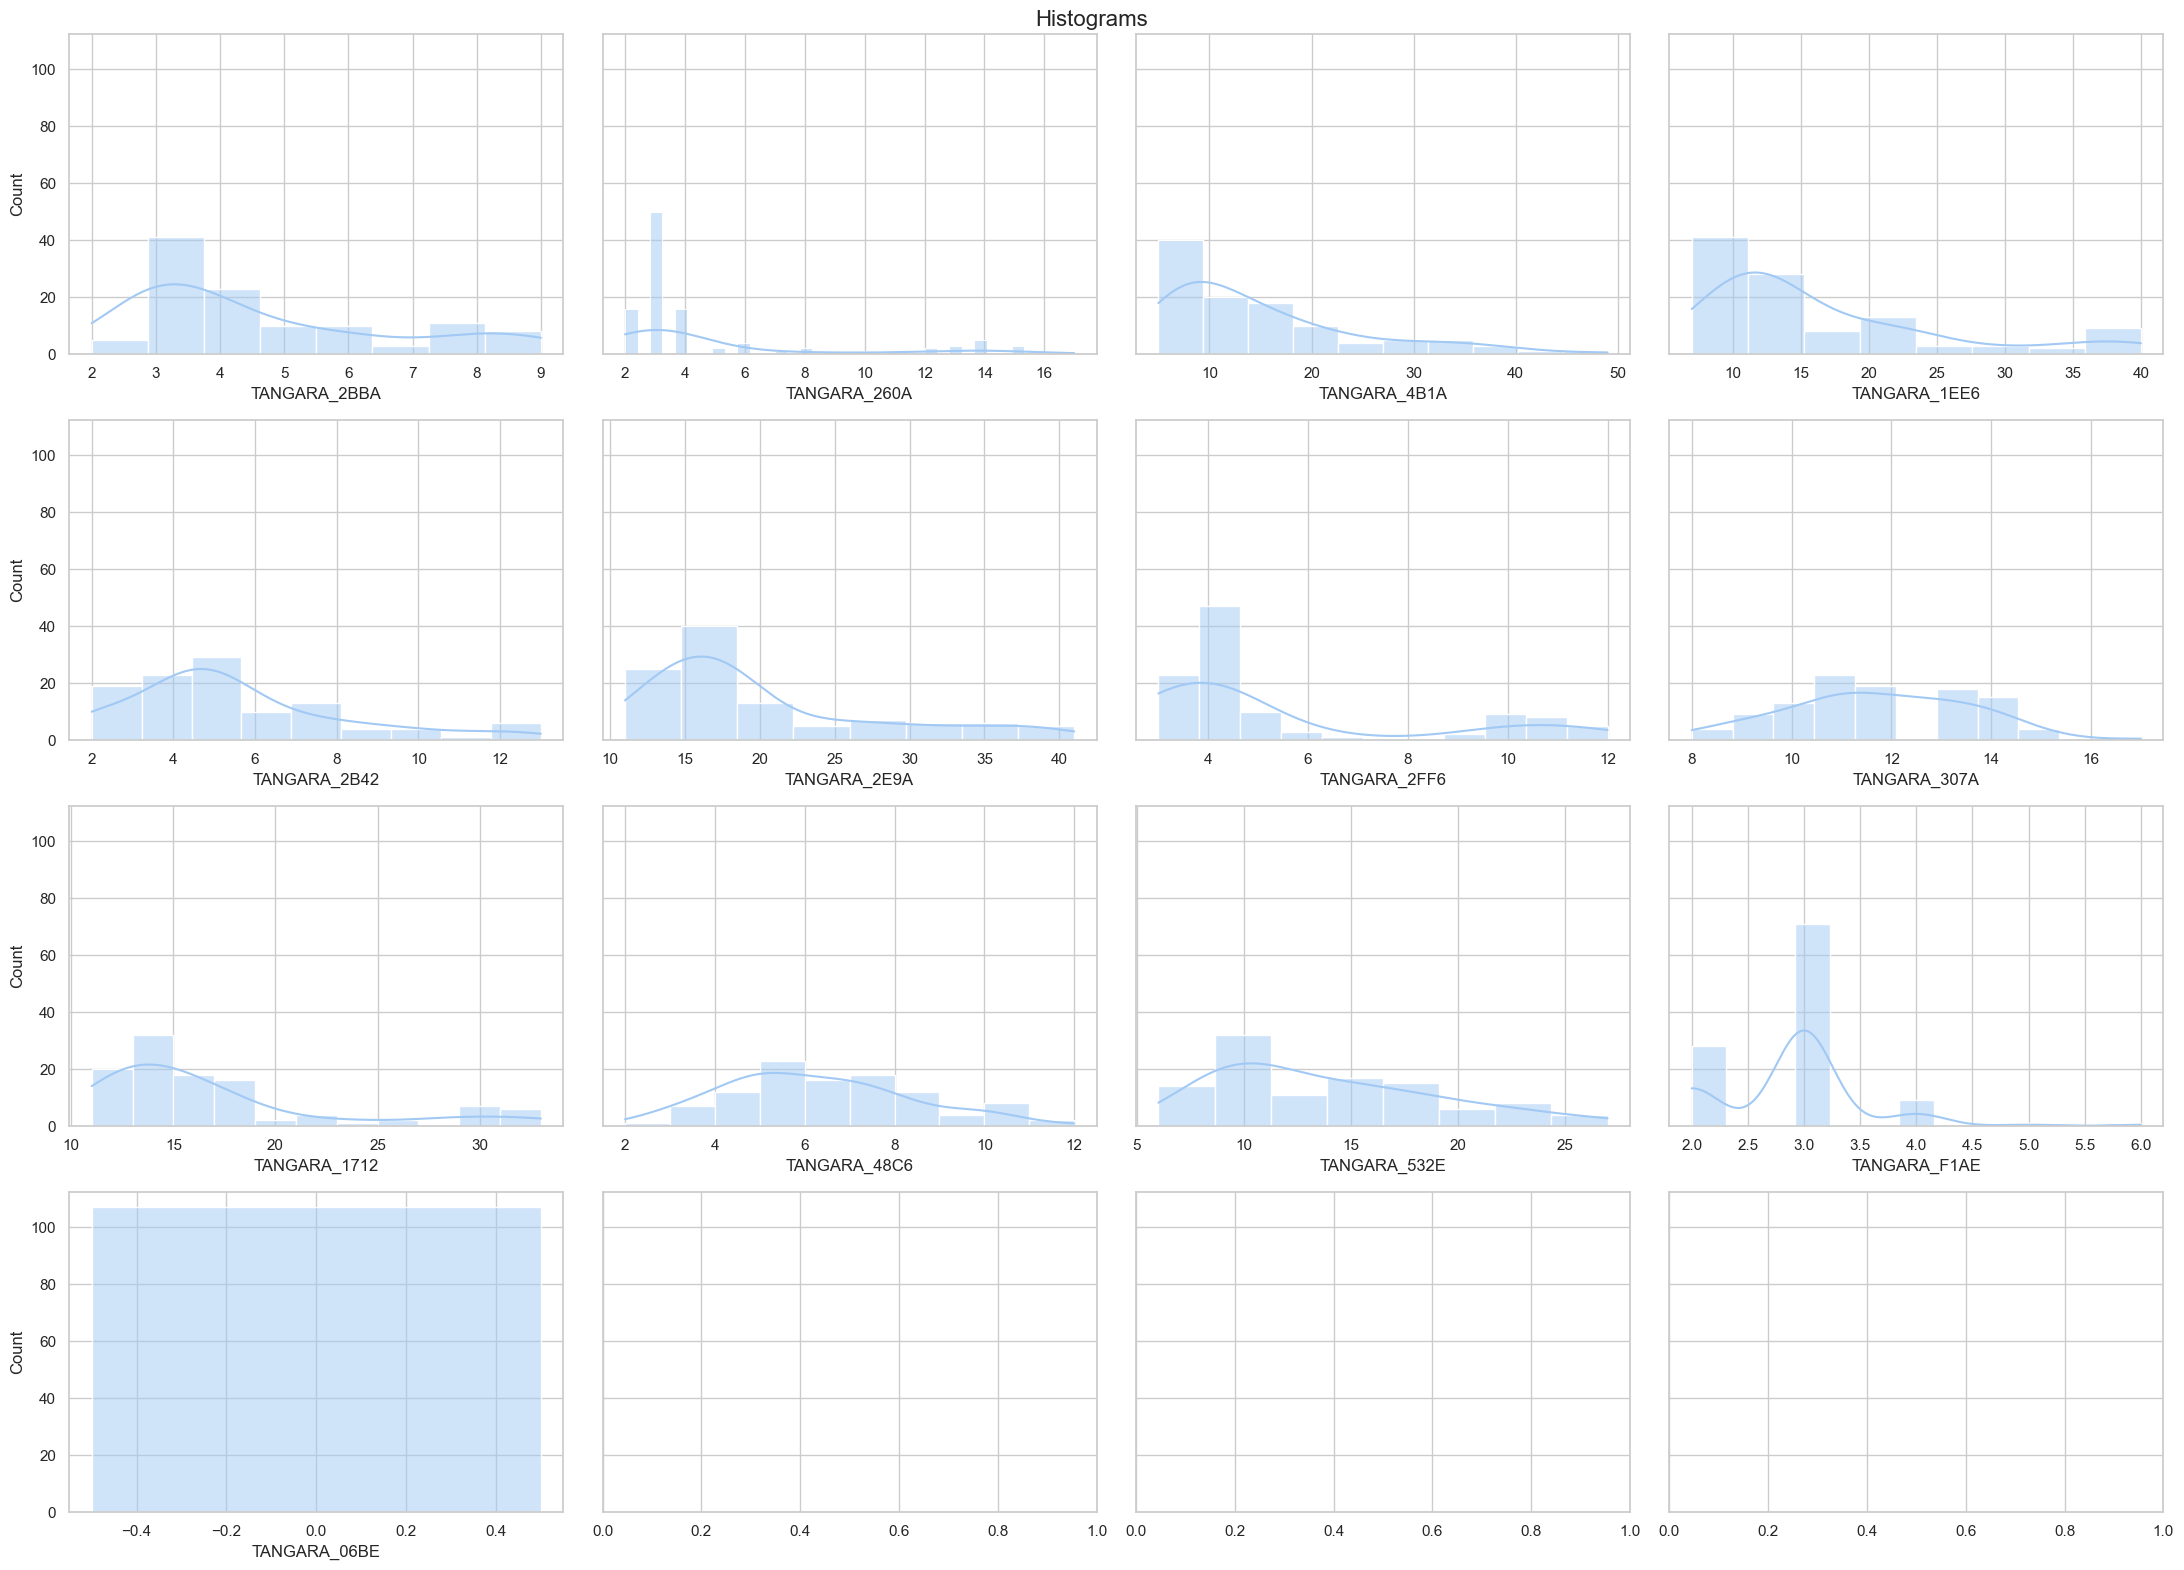

In [6]:
# Plot Histograms
plot_hist(df_pm25_raw)

## Boxplots

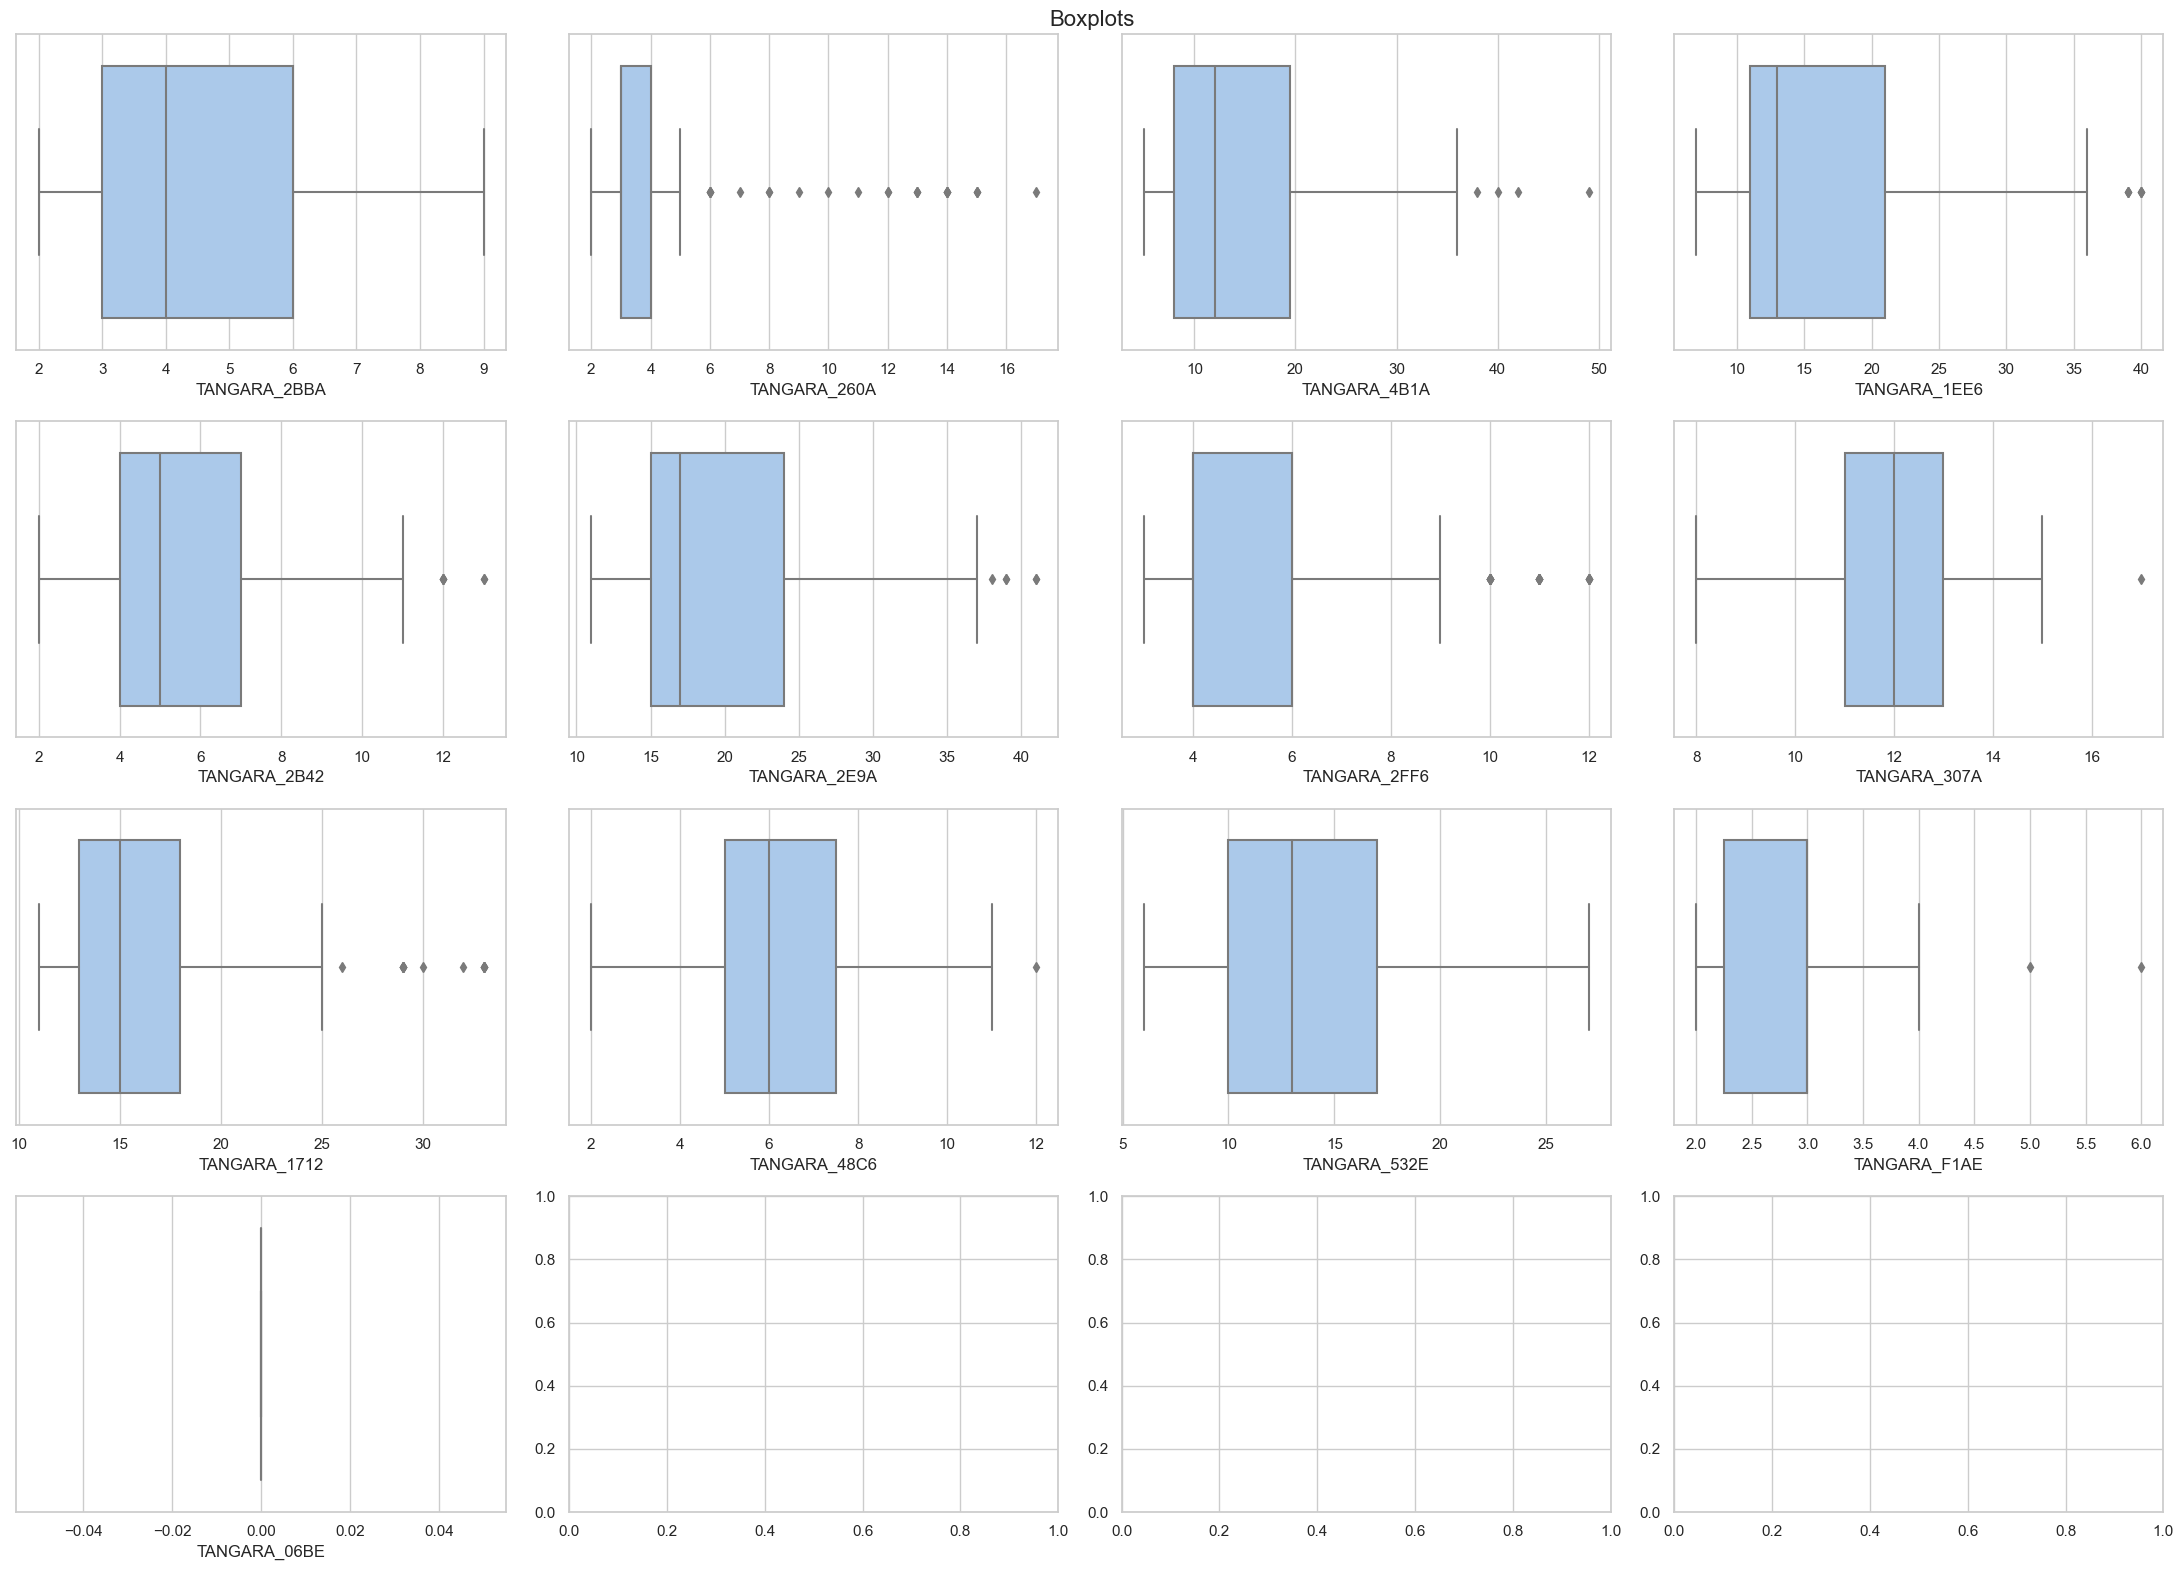

In [7]:
# Plot Boxplots
plot_boxes(df_pm25_raw)

## Lineplots

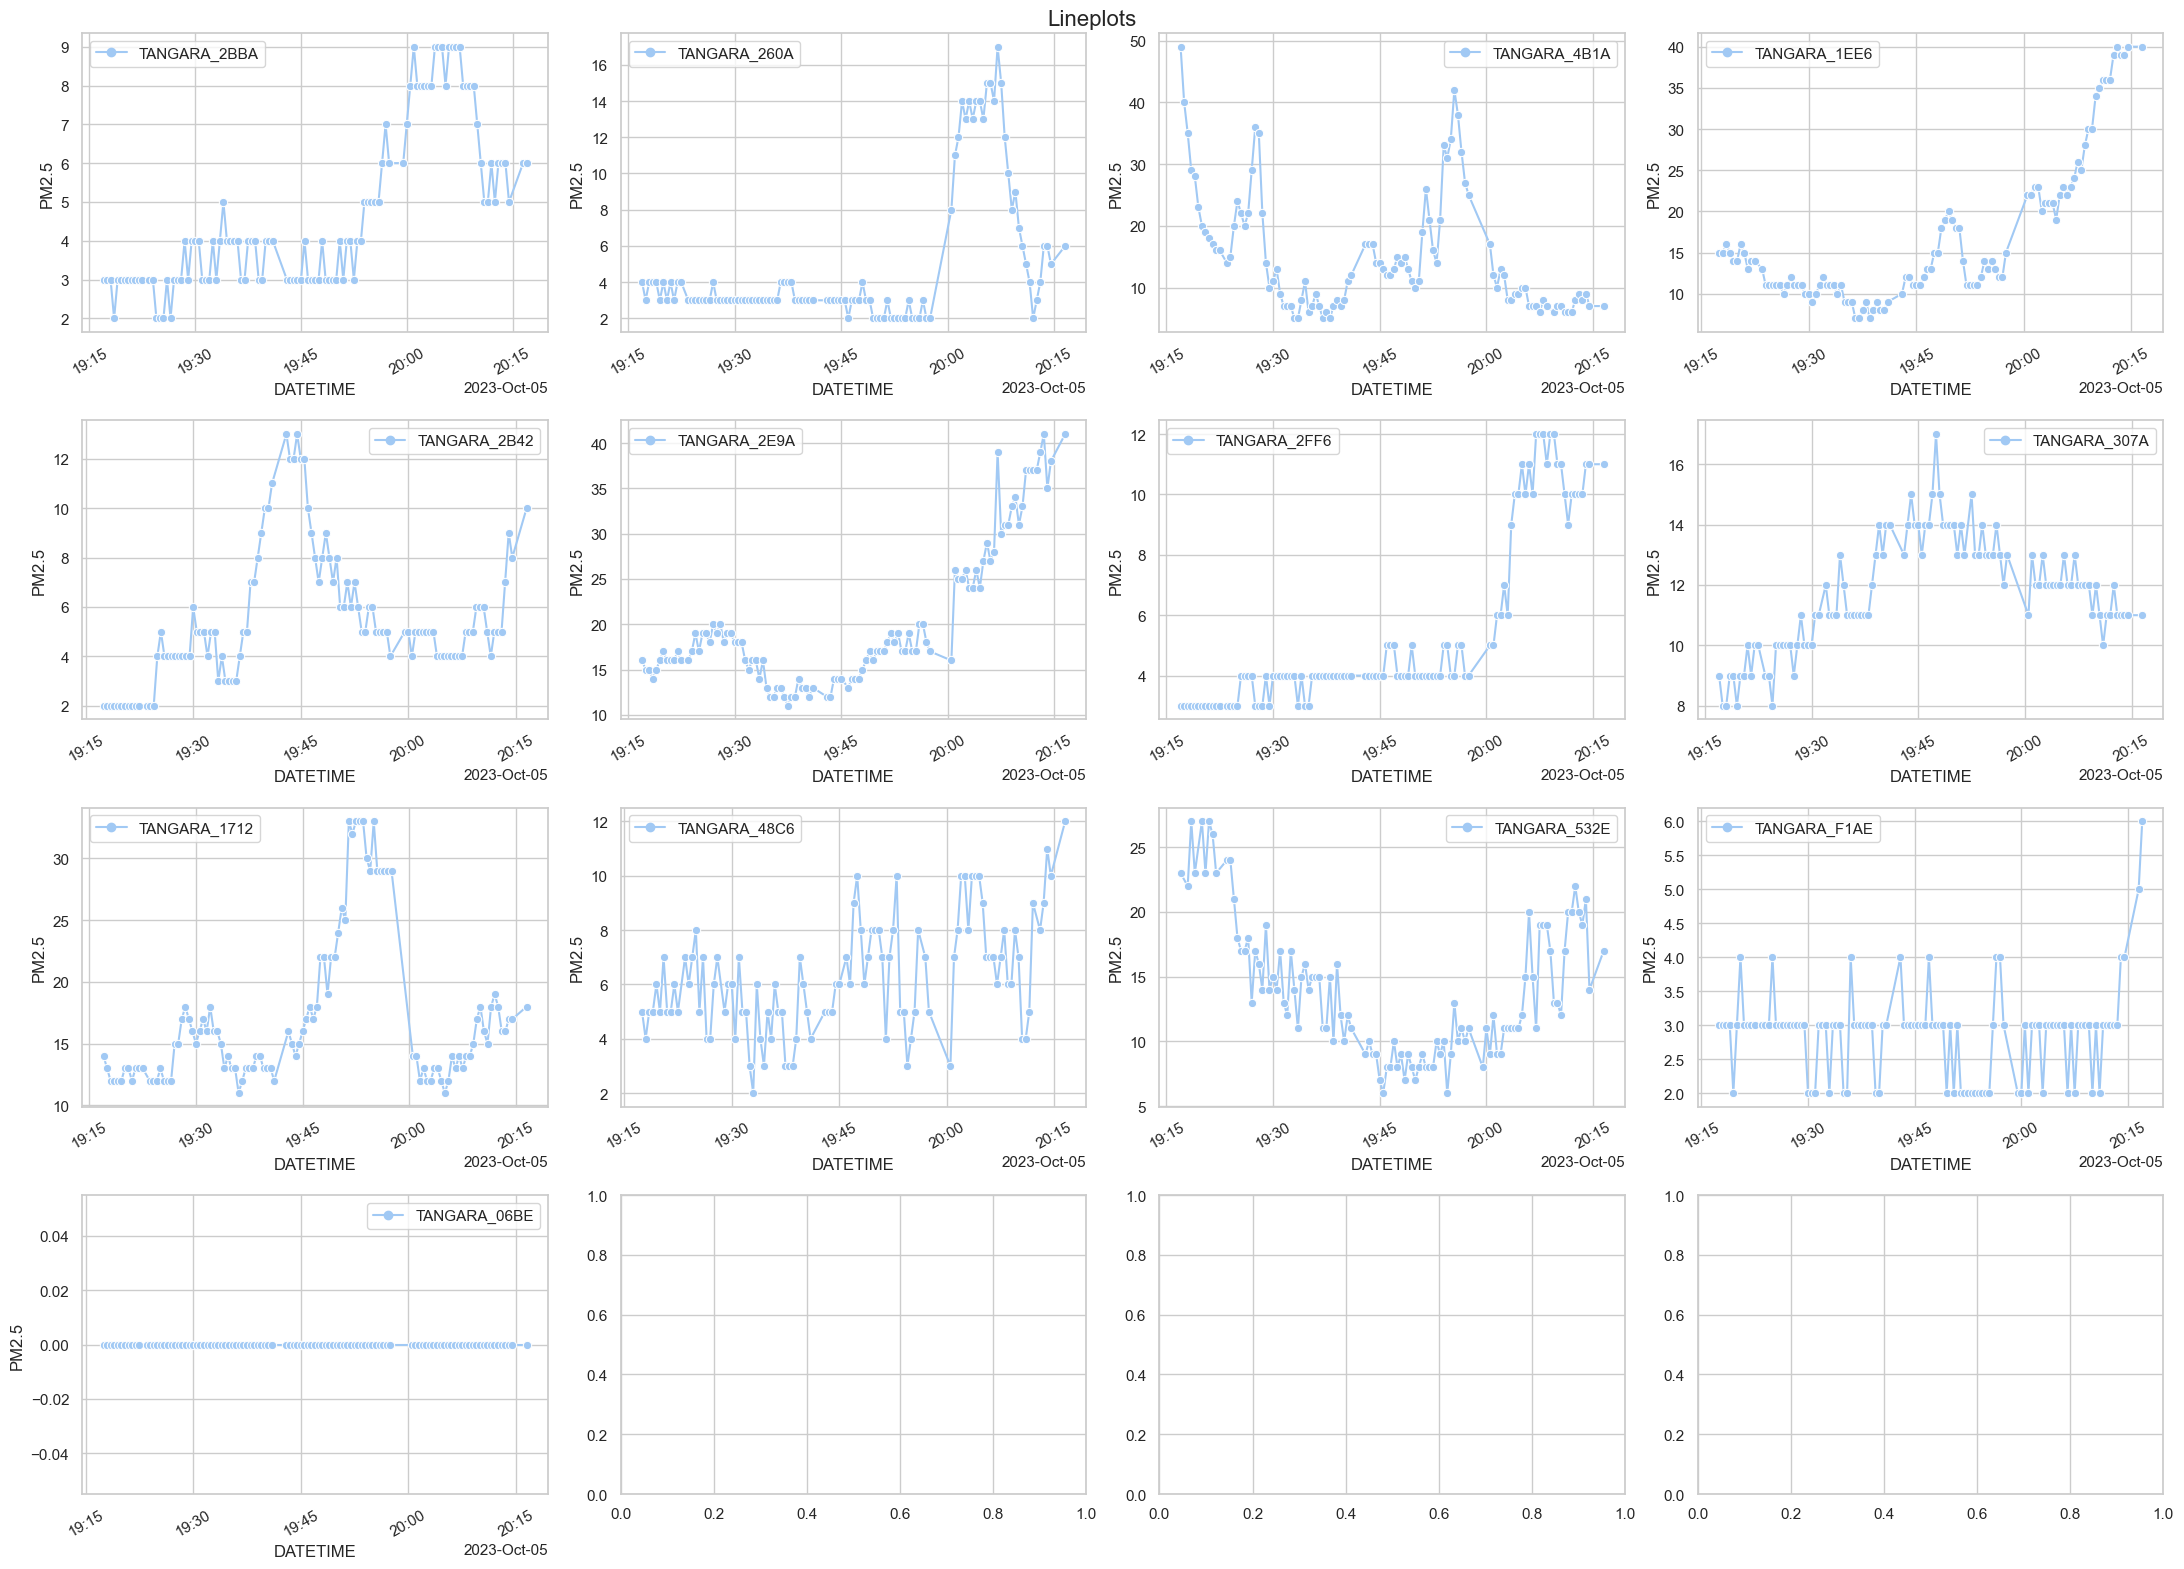

In [8]:
# Plot Lineplots
plot_lines(df_pm25_raw)

## Drop PM2.5 Outliers

In [9]:
# Drop PM2.5 Outliers
df_pm25_clean, resume = drop_pm25_outliers(df_pm25_raw)

In [10]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,111.000000,84.000000,103.000000,101.000000,103.000000,102.000000,86.000000,105.000000,94.000000,102.000000,107.000000,108.000000,107.0
mean,4.648649,3.047619,14.058252,15.346535,5.087379,19.176471,4.069767,11.695238,14.893617,6.186275,13.981308,2.824074,0.0
std,2.061106,0.692555,8.055963,7.006334,2.124123,6.693298,1.103904,1.765720,2.952921,1.993705,5.268241,0.560852,0.0
min,2.000000,2.000000,5.000000,7.000000,2.000000,11.000000,3.000000,8.000000,11.000000,2.000000,6.000000,2.000000,0.0
25%,3.000000,3.000000,7.500000,11.000000,4.000000,15.000000,3.000000,11.000000,13.000000,5.000000,10.000000,2.000000,0.0
50%,4.000000,3.000000,12.000000,13.000000,5.000000,17.000000,4.000000,12.000000,14.000000,6.000000,13.000000,3.000000,0.0
75%,6.000000,3.000000,17.500000,19.000000,6.000000,20.000000,4.000000,13.000000,16.750000,7.000000,17.000000,3.000000,0.0
max,9.000000,5.000000,36.000000,36.000000,11.000000,37.000000,9.000000,15.000000,25.000000,11.000000,27.000000,4.000000,0.0


In [11]:
# Describe Data
df_pm25_clean.describe()

,TANGARA_2BBA,TANGARA_260A,TANGARA_4B1A,TANGARA_1EE6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,111.000000,84.000000,103.000000,101.000000,103.000000,102.000000,86.000000,105.000000,94.000000,102.000000,107.000000,108.000000,107.0
mean,4.648649,3.047619,14.058252,15.346535,5.087379,19.176471,4.069767,11.695238,14.893617,6.186275,13.981308,2.824074,0.0
std,2.061106,0.692555,8.055963,7.006334,2.124123,6.693298,1.103904,1.765720,2.952921,1.993705,5.268241,0.560852,0.0
min,2.000000,2.000000,5.000000,7.000000,2.000000,11.000000,3.000000,8.000000,11.000000,2.000000,6.000000,2.000000,0.0
25%,3.000000,3.000000,7.500000,11.000000,4.000000,15.000000,3.000000,11.000000,13.000000,5.000000,10.000000,2.000000,0.0
50%,4.000000,3.000000,12.000000,13.000000,5.000000,17.000000,4.000000,12.000000,14.000000,6.000000,13.000000,3.000000,0.0
75%,6.000000,3.000000,17.500000,19.000000,6.000000,20.000000,4.000000,13.000000,16.750000,7.000000,17.000000,3.000000,0.0
max,9.000000,5.000000,36.000000,36.000000,11.000000,37.000000,9.000000,15.000000,25.000000,11.000000,27.000000,4.000000,0.0


## Histograms

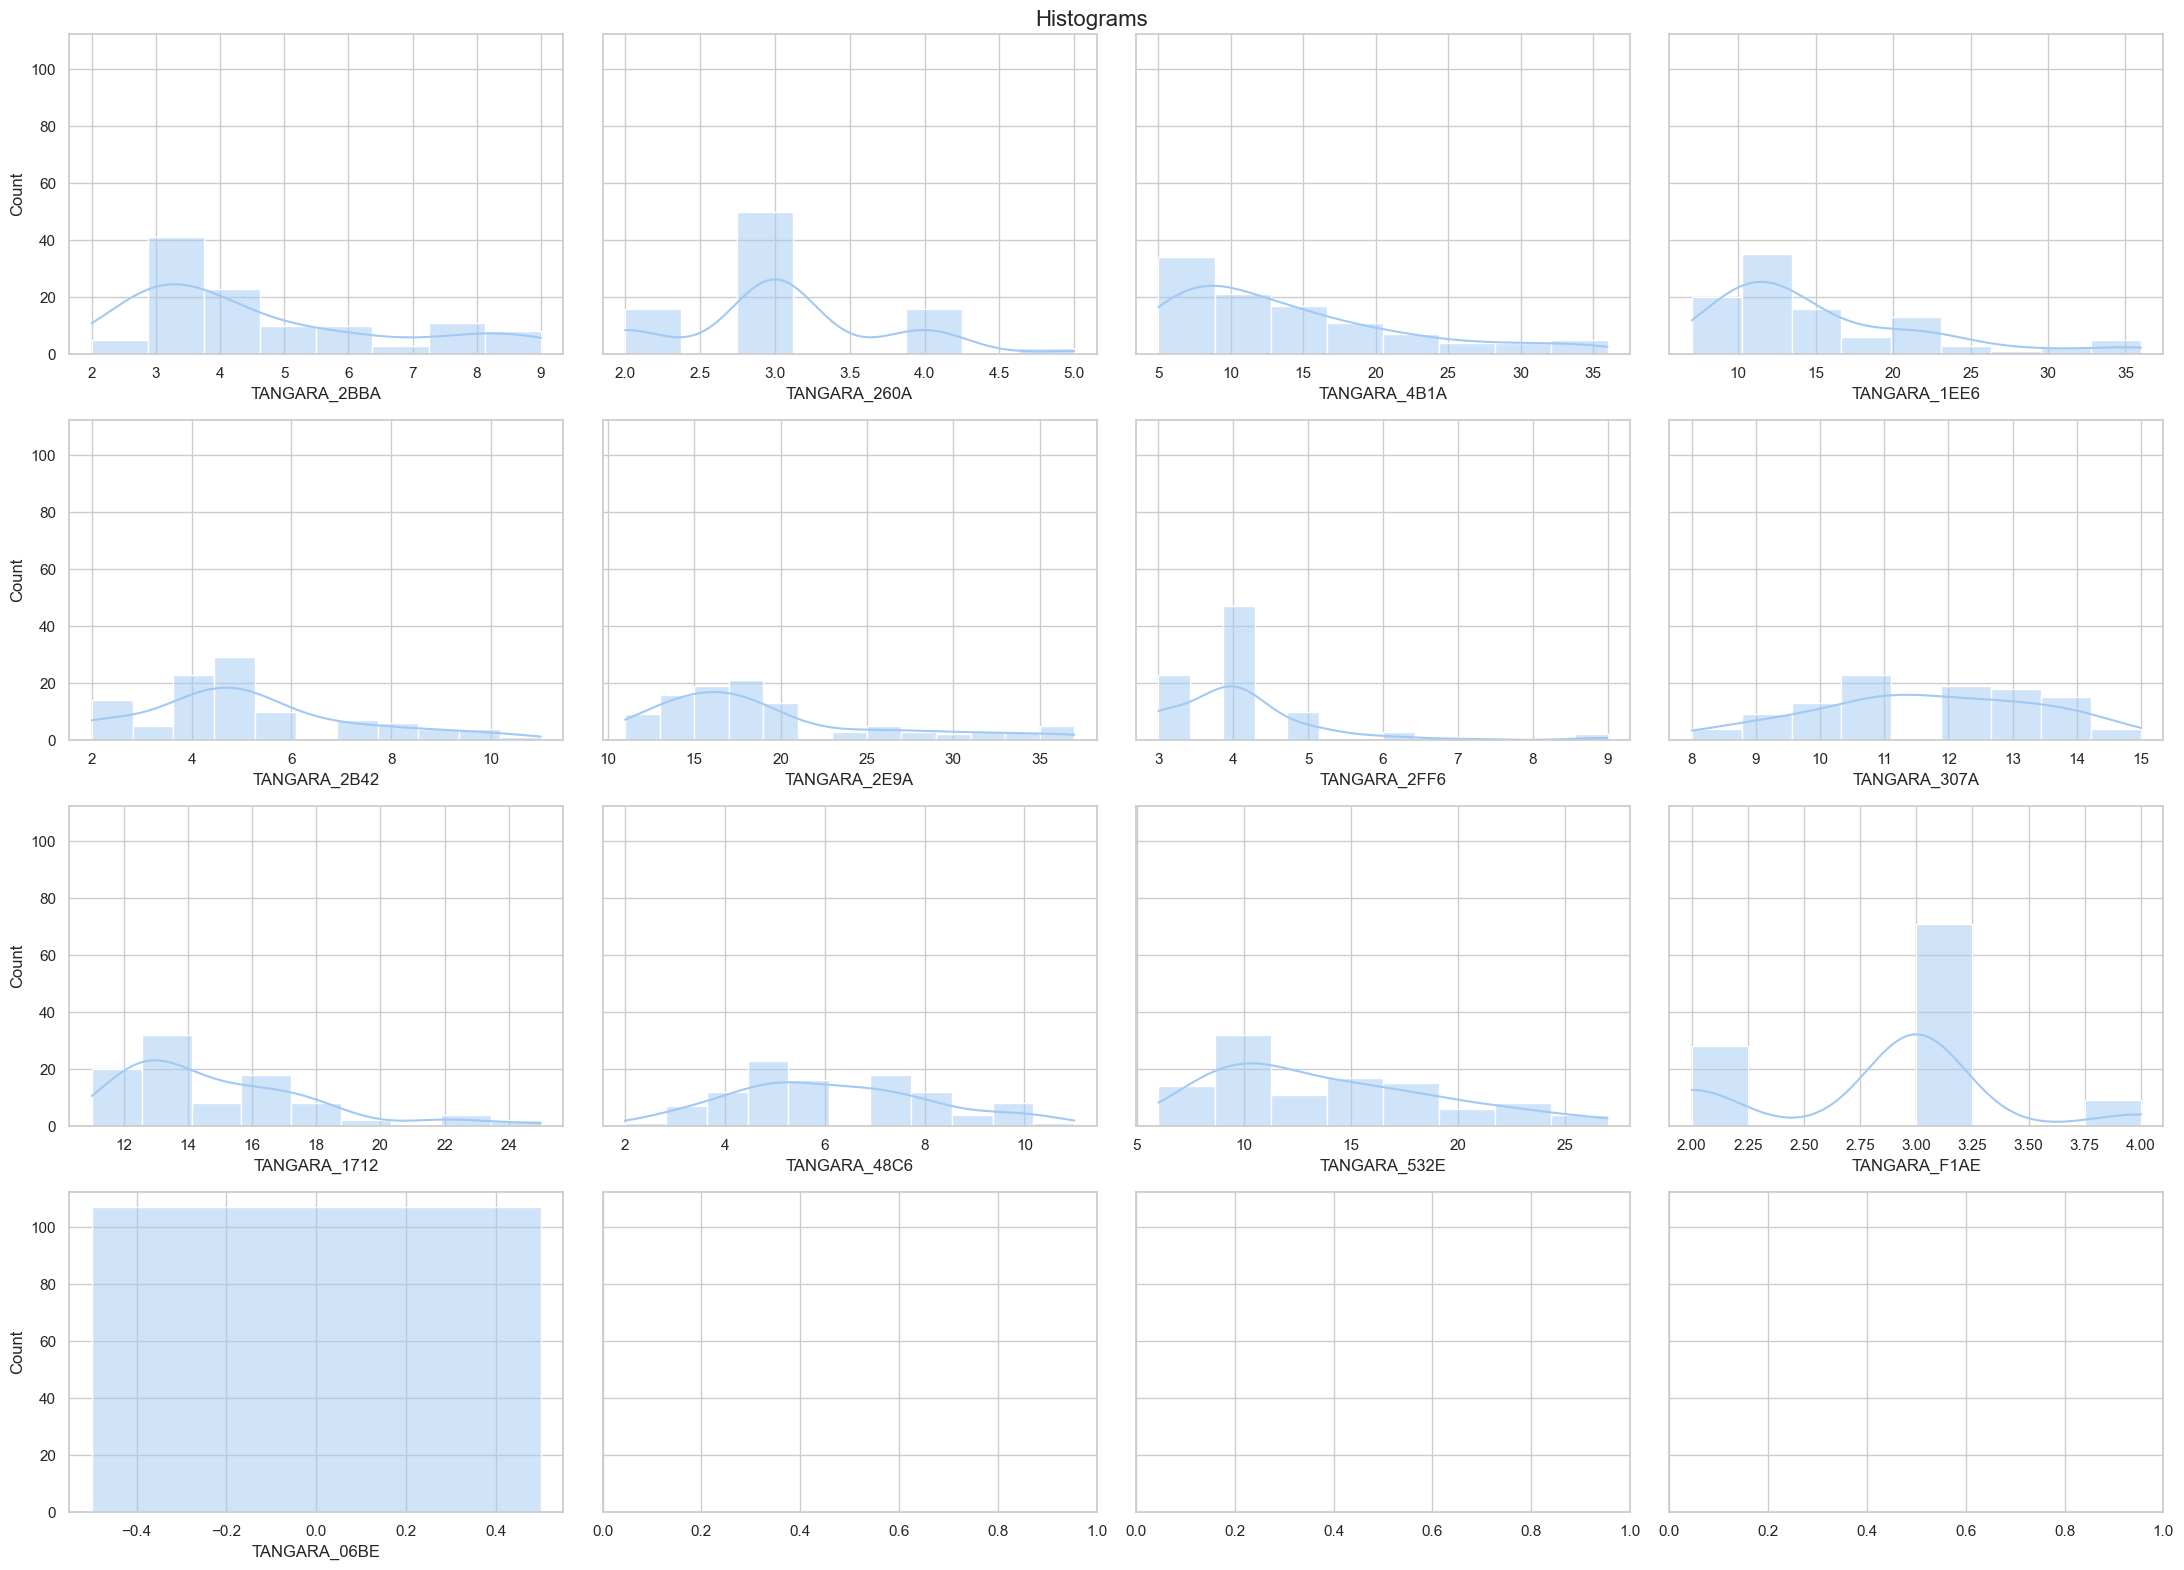

In [12]:
# Plot Histograms
plot_hist(df_pm25_clean)

## Boxplots

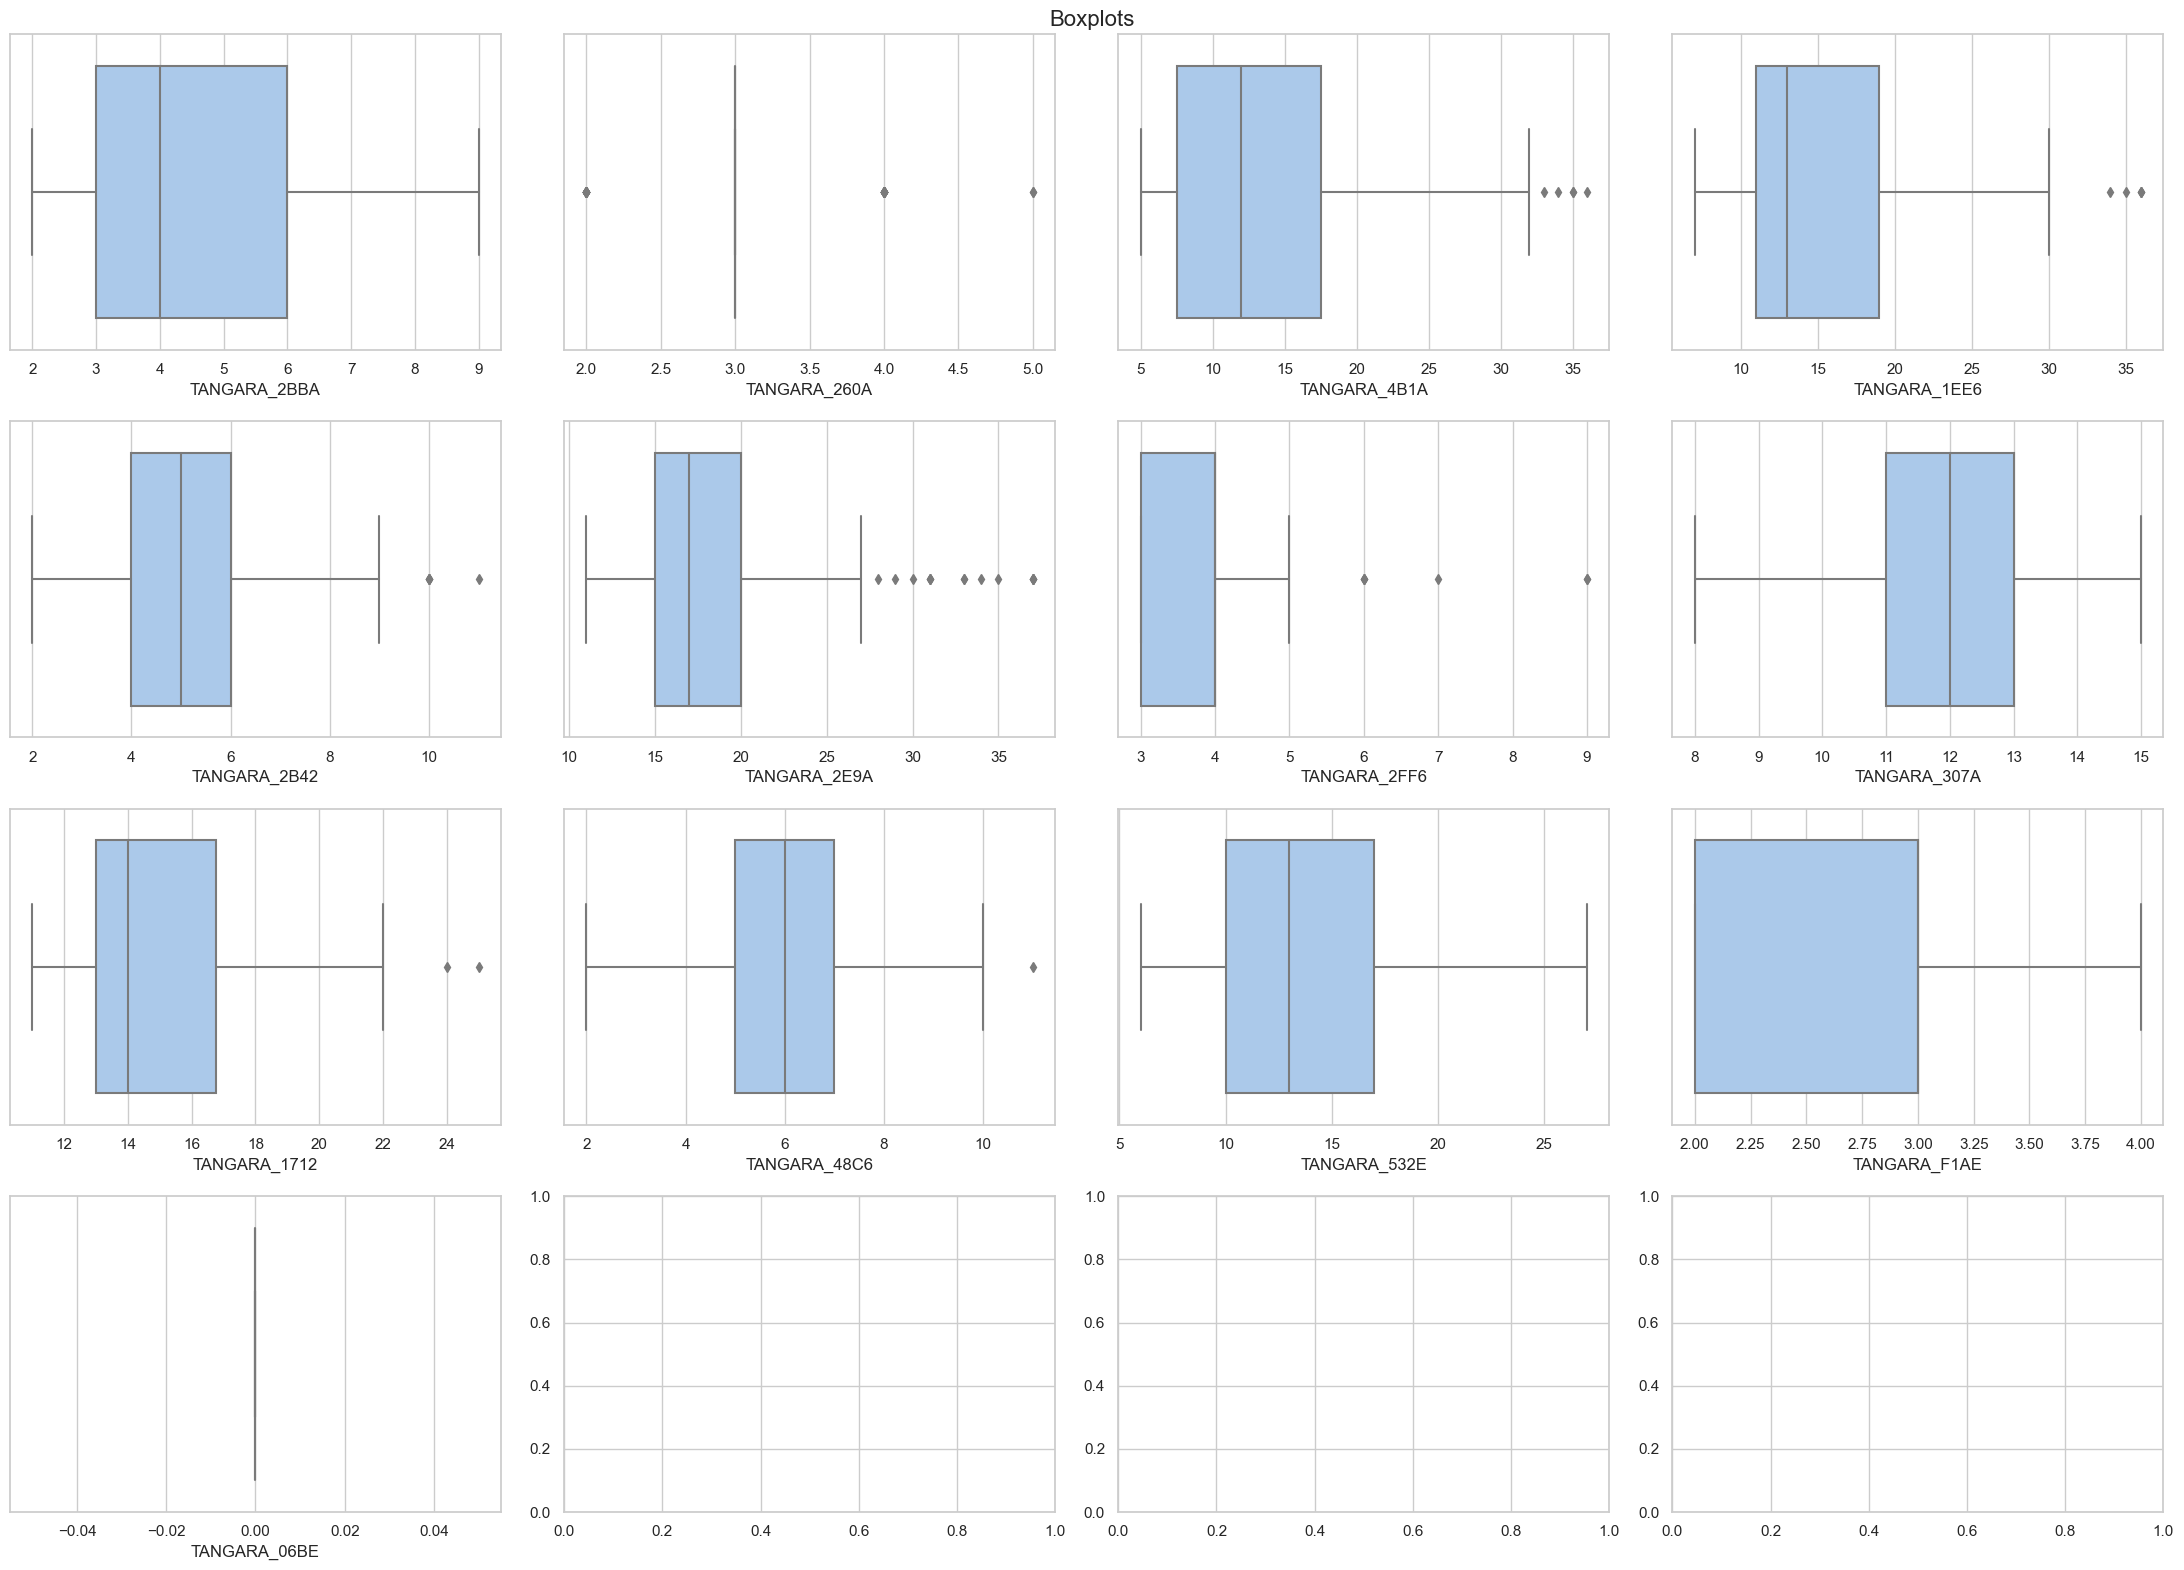

In [13]:
# Plot Boxplots
plot_boxes(df_pm25_clean)

## Lineplots

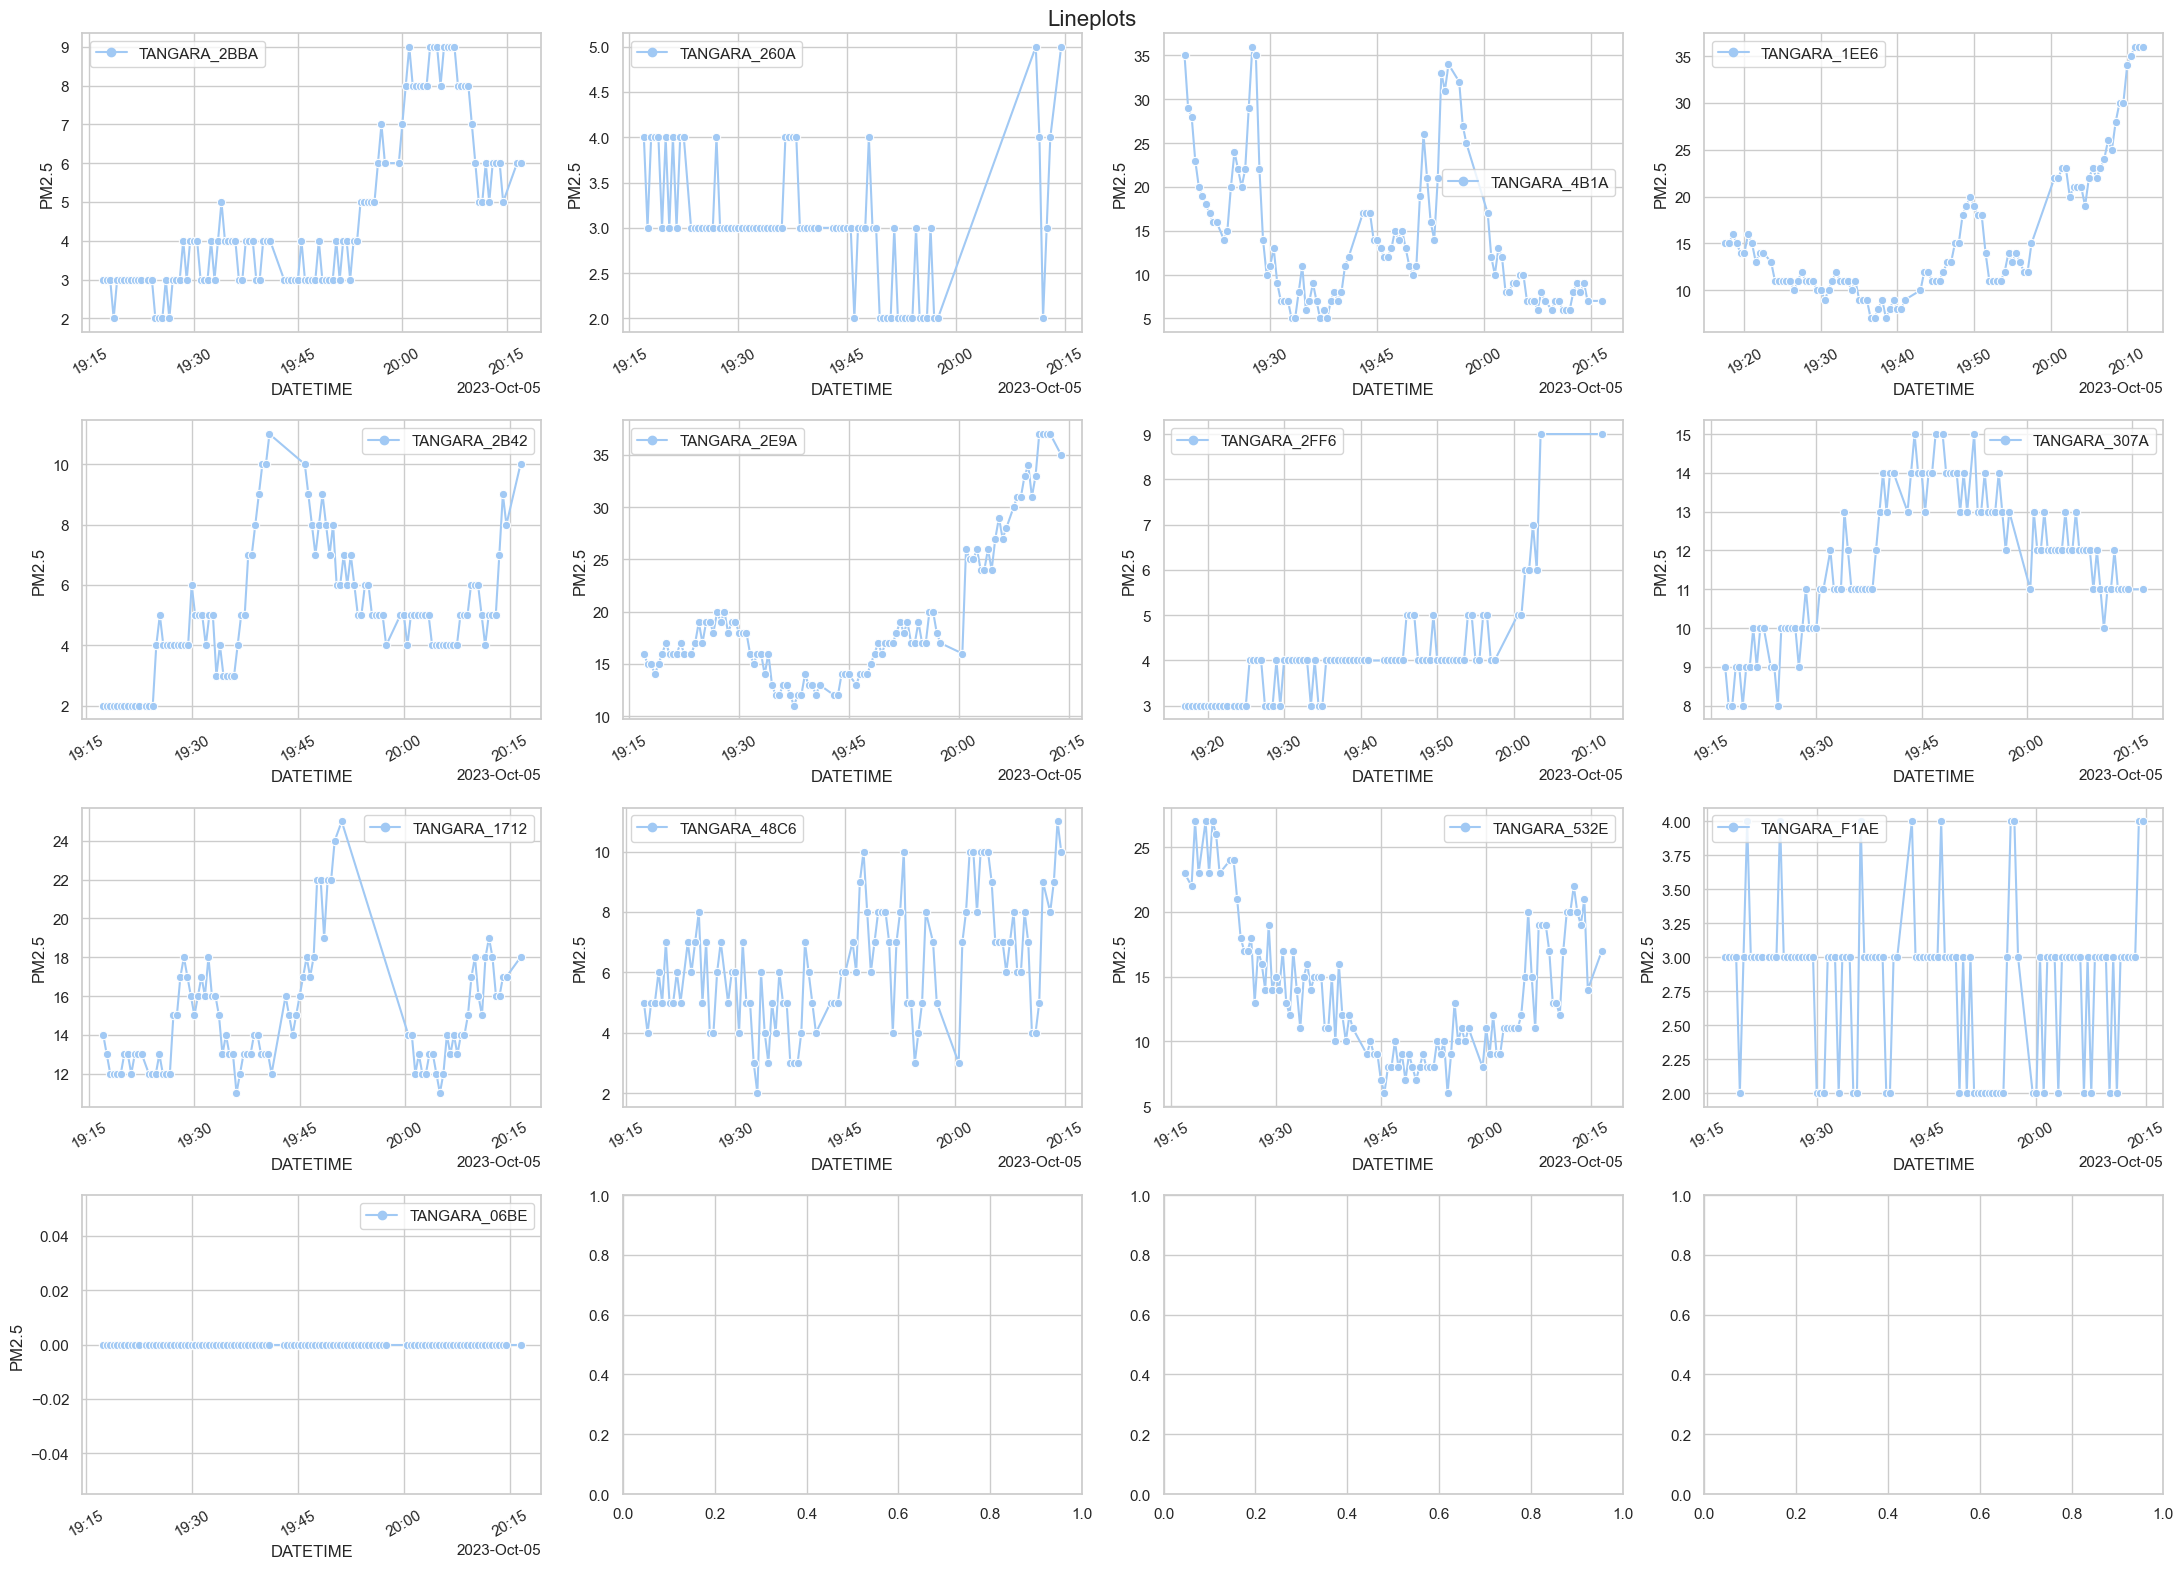

In [14]:
# Plot Lineplots
plot_lines(df_pm25_clean)

In [15]:
# Save PM2.5 Data Frame Sensors into CSV file
df_to_csv(df_pm25_clean, "pm25_clean.csv", datafolder='1_clean')